In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import scipy.optimize as sco
from datetime import datetime

# Define today's date (October 12, 2024)
today = datetime(2024, 10, 12)

# Descargar datos de múltiples empresas tecnológicas (Últimos 2 años)
tech_tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'META', 'NFLX', 'NVDA', 
                'INTC', 'ADBE', 'IBM', 'CSCO', 'ORCL', 'QCOM', 'CRM', 'AMD', 'MU', 
                'TXN', 'AVGO', 'NOW', 'UBER', 'SNAP', 'DOCU', 'ZM', 'ARM', 'TSM',
                'TCEHY', 'SHOP', 'PINS', 'CRWD', 'NET', 'DDOG', 'OKTA', 'ZS', 'MDB',
                'FROG', 'U', 'PATH', 'UPST', 'RBLX', 'SE', 'ROKU', 'CRSP', 'EDIT']

# Descargar datos desde enero de 2022 hasta el presente
tech_data = yf.download(tech_tickers, start='2022-01-01', end=today)

# Calcular retornos diarios y anuales
returns_daily = tech_data['Adj Close'].pct_change()
returns_annual = returns_daily.mean() * 252  # Aproximadamente 252 días de trading al año

# Calcular volatilidad anual
volatility_annual = returns_daily.std() * np.sqrt(252)

# Función para calcular indicadores financieros: SMA, RSI, MACD, y Estocástico
def calculate_indicators(data):
    data['SMA_20'] = data['Adj Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()

    # RSI (14-period)
    delta = data['Adj Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    
    # MACD (12, 26, 9)
    EMA_12 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    EMA_26 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = EMA_12 - EMA_26
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands
    data['Bollinger_Upper'] = data['SMA_20'] + 2 * data['Adj Close'].rolling(window=20).std()
    data['Bollinger_Lower'] = data['SMA_20'] - 2 * data['Adj Close'].rolling(window=20).std()
    
    # Estocástico (%K y %D)
    data['Lowest_Low'] = data['Adj Close'].rolling(window=14).min()
    data['Highest_High'] = data['Adj Close'].rolling(window=14).max()
    data['%K'] = (data['Adj Close'] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low']) * 100
    data['%D'] = data['%K'].rolling(window=3).mean()  # Suavizado de %K
    
    return data

# Aplicar indicadores financieros a cada ticker
indicator_data = []
for ticker in tech_tickers:
    try:
        ticker_data = tech_data[['Adj Close']].loc[:, ('Adj Close', ticker)].dropna().to_frame(name='Adj Close')
        ticker_data = calculate_indicators(ticker_data)
        ticker_data['Target'] = np.where((ticker_data['Adj Close'].pct_change(1) > 0.005), 1, 0)  # Definir target
        indicator_data.append(ticker_data)
    except Exception as e:
        print(f"Error en {ticker}: {e}")

# Concatenar todos los DataFrames de las empresas en uno solo
tech_indicators = pd.concat(indicator_data, keys=tech_tickers, axis=1)

# Concatenar los datos de todas las empresas
X_list = []
y_list = []

for ticker in tech_tickers:
    X_ticker = tech_indicators[ticker][['SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal', 'Bollinger_Upper', 
                                        'Bollinger_Lower', '%K', '%D']].dropna()
    y_ticker = tech_indicators[ticker]['Target'].dropna()

    # Alinear índices para que coincidan
    X_ticker, y_ticker = X_ticker.align(y_ticker, join='inner', axis=0)
    
    X_list.append(X_ticker)
    y_list.append(y_ticker)

# Concatenar todas las empresas en un solo DataFrame
X = pd.concat(X_list)
y = pd.concat(y_list)

# Convertir a NumPy arrays
X = X.values
y = y.values

# Dividir en entrenamiento y prueba (usando TimeSeriesSplit para asegurarnos de que el orden temporal se respete)
tscv = TimeSeriesSplit(n_splits=5)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Usar el último split para el conjunto de prueba (hasta octubre 2024)
for train_index, test_index in tscv.split(X_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

"""
# Diccionario que contiene los hiperparámetros de cada modelo
param_grids = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],  
            'max_depth': [5, 10],   
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1], 
        'max_depth': [3, 5]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'max_iter': [500, 1000]
        }
    }
}

# Función para realizar la búsqueda de hiperparámetros
def perform_grid_search(model_name, model, params, X_train, y_train):
    print(f"Realizando GridSearchCV para {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='f1', n_jobs=-1)  # Optimizando para F1
    grid_search.fit(X_train, y_train)
    print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Lista para almacenar los mejores estimadores
best_estimators = {}

# Realizar GridSearchCV para cada modelo
for model_name, config in param_grids.items():
    best_estimators[model_name] = perform_grid_search(model_name, config['model'], config['params'], X_train, y_train)

# Crear el VotingClassifier con los mejores estimadores, ajustando pesos
voting_clf = VotingClassifier(
    estimators=[
        ('RandomForest', best_estimators['RandomForest']), 
        ('GradientBoosting', best_estimators['GradientBoosting']), 
        ('LogisticRegression', best_estimators['LogisticRegression'])
    ], 
    voting='soft',
    weights=[2, 2, 1]  # Dar mayor peso a los mejores modelos
)
"""

# Crear el VotingClassifier con los mejores estimadores, ajustando pesos
voting_clf = VotingClassifier(
    estimators=[
        ('RandomForest', RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=100)),
        ('GradientBoosting', GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)),
        ('LogisticRegression', LogisticRegression(C=1, max_iter=500))
    ], 
    voting='soft',
    weights=[2, 2, 1]  # Dar mayor peso a los mejores modelos
)

# Entrenar el modelo de ensamble con los mejores hiperparámetros
voting_clf.fit(X_train, y_train)

# Evaluar el modelo de ensamble
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]  # Probabilidad de la clase 1 (subida)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)  # Ajuste el umbral aquí si es necesario

print("\nResultados del Ensamble:")
print(f"\t\tAccuracy: {accuracy_score(y_test, y_pred)}")
print(f"\t\tPrecision: {precision_score(y_test, y_pred)}")
print(f"\t\tRecall: {recall_score(y_test, y_pred)}")
print(f"\t\tF1 Score: {f1_score(y_test, y_pred)}")


[*********************100%%**********************]  44 of 44 completed



Resultados del Ensamble:
		Accuracy: 0.8676821435125711
		Precision: 0.9888449918661399
		Recall: 0.8634334415584416
		F1 Score: 0.9218936193261835


In [3]:
# Optimización del portafolio para maximizar el Sharpe Ratio
cov_matrix = returns_daily.cov() * 252
returns_matrix = returns_annual

# Inicializar pesos aleatorios
weights = np.random.random(len(tech_tickers))
weights /= np.sum(weights)

# Descargar datos del US Treasury Bill a 3 meses
treasury_data = yf.download('^IRX', start='2015-01-01', end='2024-01-01')

# Convertir a tasa anualizada y utilizar el promedio como risk-free rate
risk_free_rate = treasury_data['Adj Close'].mean() / 100

# Definir una función para calcular el rendimiento, volatilidad y el Sharpe Ratio del portafolio
def calculate_portfolio_performance(weights, returns_matrix, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, returns_matrix)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Definir la función objetivo (negativa porque queremos maximizar el Sharpe Ratio)
def negative_sharpe_ratio(weights, returns_matrix, cov_matrix, risk_free_rate):
    _, _, sharpe_ratio = calculate_portfolio_performance(weights, returns_matrix, cov_matrix, risk_free_rate)
    return -sharpe_ratio  # Negativo porque queremos maximizar

# Limitar los pesos individuales a un máximo del 25% (0.25)
max_weight_per_stock = 0.2
bounds = tuple((0, max_weight_per_stock) for _ in range(len(tech_tickers)))

# Restricción para que la suma de los pesos sea 1 (la suma de las ponderaciones debe ser 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Optimizar los pesos del portafolio
optimized_result = sco.minimize(negative_sharpe_ratio, weights, args=(returns_matrix, cov_matrix, risk_free_rate),
                                method='SLSQP', bounds=bounds, constraints=constraints)

# Asignar los mejores pesos encontrados
optimized_weights = optimized_result.x

# Evaluar el portafolio con los pesos optimizados
port_return, port_volatility, port_sharpe = calculate_portfolio_performance(optimized_weights, returns_matrix, cov_matrix, risk_free_rate)

print(f"\nRendimiento esperado del portafolio optimizado: {port_return}")
print(f"Volatilidad del portafolio optimizado: {port_volatility}")
print(f"Sharpe Ratio del portafolio optimizado: {port_sharpe}")

[*********************100%%**********************]  1 of 1 completed


Rendimiento esperado del portafolio optimizado: 0.5712083401356708
Volatilidad del portafolio optimizado: 0.3407377869020359
Sharpe Ratio del portafolio optimizado: 1.6352748817707428


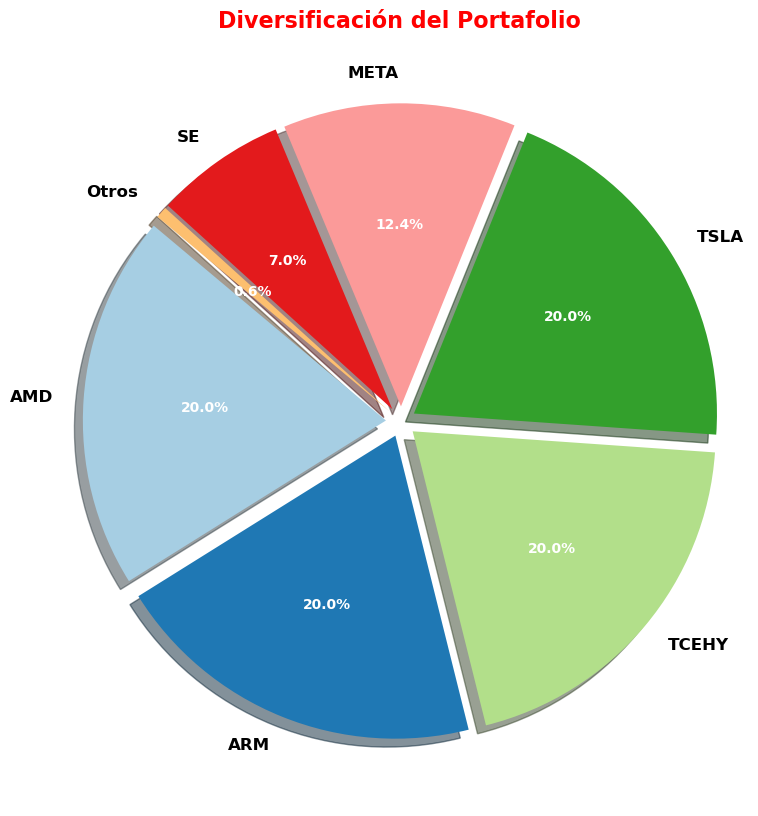

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizar la diversificación del portafolio con un gráfico de pastel
def plot_portfolio_weights(weights, tickers, threshold=0.95):
    # Ordenar los pesos en orden descendente junto con sus tickers
    sorted_indices = np.argsort(weights)[::-1]  # Orden descendente
    sorted_weights = weights[sorted_indices]
    sorted_tickers = np.array(tickers)[sorted_indices]
    
    # Calcular la suma acumulada para determinar cuándo se supera el 95% del total
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Encontrar el punto donde la suma acumulada excede el 95%
    idx_95 = np.argmax(cumulative_weights > threshold)
    
    # Dividir los pesos y etiquetas en dos grupos: 95% y "Otros"
    displayed_weights = sorted_weights[:idx_95 + 1]
    displayed_tickers = sorted_tickers[:idx_95 + 1]
    
    other_weight = np.sum(sorted_weights[idx_95 + 1:])
    if other_weight > 0:
        displayed_weights = np.append(displayed_weights, other_weight)
        displayed_tickers = np.append(displayed_tickers, 'Otros')
    
    # Personalización de colores y estilo del gráfico
    colors = plt.cm.Paired.colors  # Color map
    explode = [0.05] * len(displayed_weights)  # Separar las porciones ligeramente
    
    # Graficar el pastel con sombras, explosión y colores personalizados
    plt.figure(figsize=(9, 10), dpi=100)
    wedges, texts, autotexts = plt.pie(
        displayed_weights, labels=displayed_tickers, autopct='%1.1f%%', startangle=140, 
        colors=colors[:len(displayed_weights)], explode=explode, shadow=True
    )
    
    # Mejorar el tamaño y estilo de las etiquetas
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
        
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.axis('equal')  # Para asegurar que el gráfico sea un círculo
    plt.title('Diversificación del Portafolio', fontsize=16, fontweight='bold', color='r')
    plt.savefig('portfolio_diversification.png', dpi=100)
    plt.show()

# Llamar a la función con los pesos optimizados
plot_portfolio_weights(optimized_weights, tech_tickers)

In [10]:
# Utilizar los pesos optimizados para calcular el valor del portafolio
initial_investment = 1000000  # $1,000,000 MXN
portfolio_value = initial_investment * optimized_weights
print('Inversión inicial: $1,000,000 MXN')
print("\nValor del portafolio por acción:")
for ticker, value in zip(tech_tickers, portfolio_value):
    if value > 1:
        print(f"\t{ticker}: {value:.2f} MXN")
        
# Calcular el rendimiento total del portafolio
portfolio_return = np.dot(optimized_weights, returns_matrix)
portfolio_return *= initial_investment
print(f"\nRendimiento total del portafolio: {portfolio_return:.2f} MXN")

Inversión inicial: $1,000,000 MXN

Valor del portafolio por acción:
	TSLA: 200000.00 MXN
	META: 123990.73 MXN
	AMD: 200000.00 MXN
	AVGO: 6157.09 MXN
	ARM: 200000.00 MXN
	TCEHY: 200000.00 MXN
	SE: 69852.18 MXN

Rendimiento total del portafolio: 571208.34 MXN
